# KyuPy Introduction

This notebook introduces KyuPy's basic data structures and built-in functions step-by-step.

## Working With Gate-Level Circuit Structures

KyuPy has two parser modules:

* `kyupy.bench`: The [ISCAS'89 Benchmark Format](https://www.researchgate.net/profile/Franc-Brglez/publication/224723140_Combination_profiles_of_sequential_benchmark_circuits) ".bench"
* `kyupy.verilog`: Non-hierarchical gate-level verilog

Files can be loaded using `.load(file)`, strings can be parsed using `.parse(text)`.

In [1]:
from kyupy import bench, verilog
from kyupy.techlib import SAED32, GSC180

# load a file
b15 = verilog.load('../tests/b15_2ig.v.gz', tlib=SAED32)

# ... or specify the circuit as string 
adder = verilog.parse('''
module adder(clk, a, b, s);
    input clk, a, b;
    output s;
    wire cin, cout;
    DFFX1 carry (.D(cout), .CK(clk), .Q(cin));
    ADDFX1 adder (.A(a), .B(b), .CI(cin), .CO(cout), .S(s));
endmodule
''', tlib=GSC180)

They return KyuPy's intermediate prepresentation of the circuit graph (objects of class `kyupy.circuit.Circuit`):

In [2]:
type(b15)

kyupy.circuit.Circuit

In [3]:
b15

{name: "b15", cells: 10789, forks: 10749, lines: 32032, io_nodes: 111}

In [4]:
adder

{name: "adder", cells: 6, forks: 6, lines: 12, io_nodes: 4}

The `.stats` property returns a dictionary with more detailed statistics on the elements in the circuit.

In [5]:
adder.stats

{'__node__': 12,
 '__cell__': 6,
 '__fork__': 6,
 '__io__': 4,
 '__line__': 12,
 'DFFX1': 1,
 '__dff__': 1,
 'ADDFX1': 1,
 '__comb__': 1,
 'input': 3,
 'output': 1,
 '__latch__': 0,
 '__seq__': 1}

In [6]:
b15.stats

{'__node__': 21538,
 '__cell__': 10789,
 '__fork__': 10749,
 '__io__': 111,
 '__line__': 32032,
 'TIEH_RVT': 1,
 '__comb__': 10261,
 'NBUFFX4_RVT': 114,
 'NBUFFX2_RVT': 371,
 'INVX2_RVT': 27,
 'NBUFFX8_RVT': 40,
 'INVX0_RVT': 769,
 'AND2X1_RVT': 996,
 'OR2X1_RVT': 1087,
 'OR2X2_RVT': 8,
 'INVX8_RVT': 30,
 'NOR2X2_RVT': 20,
 'INVX4_RVT': 36,
 'AND2X2_RVT': 50,
 'SDFFARX1_RVT': 412,
 '__dff__': 417,
 'NAND2X0_RVT': 6596,
 'NOR2X0_RVT': 74,
 'NOR2X1_RVT': 15,
 'NAND2X1_RVT': 3,
 'NOR2X4_RVT': 5,
 'NAND2X2_RVT': 9,
 'SDFFARX2_RVT': 5,
 'NAND2X4_RVT': 3,
 'AND2X4_RVT': 1,
 'INVX32_RVT': 4,
 'INVX16_RVT': 1,
 'NBUFFX32_RVT': 1,
 'output': 71,
 'input': 40,
 '__latch__': 0,
 '__seq__': 417}

The `.dot()` function shows the graph structure for small circuits. This requires the `graphviz` package.

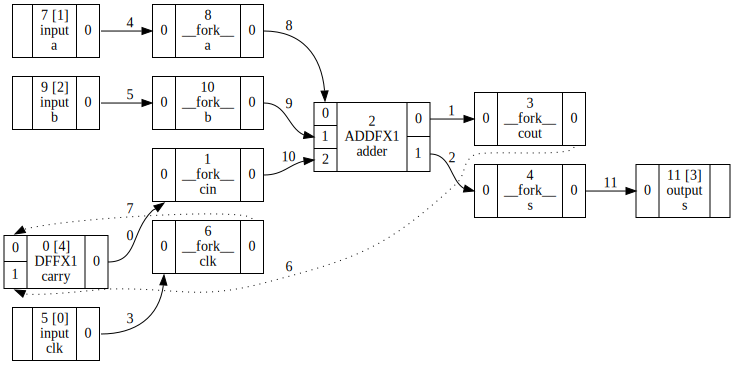

In [7]:
adder.dot()

The rectangles are called _nodes_.
Every node has an _index_ (top-middle number), a _kind_ or type (string in the middle), and a _name_ (bottom-most string).
Nodes have numeric input pins on the left and numeric output pins on the right.
The pins are connected by directional _lines_.
Lines are 1-to-1 connections and also have an _index_.

Some nodes have an additional number in brackets. These are primary inputs, primary outputs (_io_nodes_) or sequential nodes (flip-flops, _s_nodes_).
The number is the position of their corresponding data in test vectors.

The graph above is topologically sorted with primary inputs and flip-flops on the left.
Lines that follow the sorting are shown as solid, lines back to the flip-flops are shown as dotted.

Let's explore the components in more detail:

### Cells and Forks

Circuits contain `cells` and `forks` dictionaries that map names to `Node`-objects.

In [8]:
adder.cells

{'carry': 0:DFFX1"carry" <7 <6 >0,
 'adder': 2:ADDFX1"adder" <8 <9 <10 >1 >2,
 'clk': 5:input"clk" >3,
 'a': 7:input"a" >4,
 'b': 9:input"b" >5,
 's': 11:output"s" <11}

In [9]:
adder.forks

{'cin': 1:__fork__"cin" <0 >10,
 'cout': 3:__fork__"cout" <1 >6,
 's': 4:__fork__"s" <2 >11,
 'clk': 6:__fork__"clk" <3 >7,
 'a': 8:__fork__"a" <4 >8,
 'b': 10:__fork__"b" <5 >9}

Access any cell or fork by name using a simple dictionary lookup:

In [10]:
adder.cells['adder']

2:ADDFX1"adder" <8 <9 <10 >1 >2

In [11]:
adder.forks['cout']

3:__fork__"cout" <1 >6

Cells and forks are instances of class `Node`, which represent *things* that are connected to one or more other *things* in the circuit.

* A **cell** represents a gate or a standard cell.
* A **fork** represents a named signal or a fan-out point (connecting the output of one cell to multiple other cells or forks).

`Node`-objects have an `index`, a `kind`, and a `name`.

In [12]:
adder.cells['s'].index, adder.cells['s'].kind, adder.cells['s'].name

(11, 'output', 's')

*Forks* are `Node`-objects of the special kind `__fork__`.

*Cells* are `Node`-objects of any other kind. A *kind* is just a string and can be anything.

The namespaces of *forks* and *cells* are separate:
* A *cell* and a *fork* **can** have the same name.
* Two *cells* or two *forks* **cannot** have the same name.

In [13]:
adder.forks['s'].index, adder.forks['s'].kind, adder.forks['s'].name

(4, '__fork__', 's')

The `index` of a *node* in a circuit is a unique and consecutive integer.

Although *Forks* and *cells* can have the same name, they all have separate indices.

Nodes can be accessed by their index using the `nodes` list:

In [14]:
adder.nodes

[0:DFFX1"carry" <7 <6 >0,
 1:__fork__"cin" <0 >10,
 2:ADDFX1"adder" <8 <9 <10 >1 >2,
 3:__fork__"cout" <1 >6,
 4:__fork__"s" <2 >11,
 5:input"clk" >3,
 6:__fork__"clk" <3 >7,
 7:input"a" >4,
 8:__fork__"a" <4 >8,
 9:input"b" >5,
 10:__fork__"b" <5 >9,
 11:output"s" <11]

In [15]:
adder.nodes[4], adder.nodes[11]

(4:__fork__"s" <2 >11, 11:output"s" <11)

A common use for the index is to store additional data for nodes. Since the index is positive, unique, and consecutive, it can be easily used with external arrays or lists.

This is how you store an additional "weight" for each node in the circuit:

In [16]:
weights = [0] * len(adder.nodes)

Use the node instance to index into the external list. This also works with numpy arrays, of course.

In [17]:
weights[adder.cells['s']] = 5

In [18]:
weights

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5]

### Lines

A `Line` is a directional 1:1 connection between two Nodes.

A line has a circuit-unique and consecutive `index` just like nodes.

Line and node indices are different!

There is a `lines` list. If a line is printed, it just outputs its index:

In [19]:
adder.lines

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

A line one `driver`-node and one `reader`-node:

In [20]:
adder.lines[2].driver, adder.lines[2].reader

(2:ADDFX1"adder" <8 <9 <10 >1 >2, 4:__fork__"s" <2 >11)

Nodes show their connections to the lines with direction ("<" for input, ">" for output) and the line index.

In the example above, line 2 connects the output of cell "axb" to the input of fork "axb".

The input connections and output connections of a node are ordered lists of lines called `ins` and `outs`:

In [21]:
adder.cells['adder'].ins, adder.cells['adder'].outs

([8, 9, 10], [1, 2])

A line also stores its positions in the connection lists in `driver_pin` and `reader_pin`:

In [22]:
adder.lines[9].driver_pin, adder.lines[9].reader_pin

(0, 1)

### IO_Nodes

Any node in the circuit can be designated as a primary input or primary output by adding it to the `io_nodes` list:

In [23]:
adder.io_nodes

[5:input"clk" >3, 7:input"a" >4, 9:input"b" >5, 11:output"s" <11]

It is common that io_nodes either have only output connections (in a role as primary-input) or only input connections (in a role as primary-output).

Inputs and outputs appear in the order they were defined in the loaded file. Inputs and outputs are often interspersed.

A related list is `s_nodes`. It contains the io_nodes at the beginning and adds all sequential elements (flip-flops, latches).

In [24]:
adder.s_nodes

[5:input"clk" >3,
 7:input"a" >4,
 9:input"b" >5,
 11:output"s" <11,
 0:DFFX1"carry" <7 <6 >0]

### Basic Circuit Navigation

A circuit can be traversed easily using the properties of `Circuit`, `Node`, and `Line`.

In [25]:
adder.io_nodes[1].outs[0].reader

8:__fork__"a" <4 >8

In [26]:
for line in adder.cells['adder'].outs:
    print(line.reader)

3:__fork__"cout" <1 >6
4:__fork__"s" <2 >11


In [27]:
adder.forks['cout'].ins[0].driver.name

'adder'

Let's continue with `b15` loaded before. It has 111 io_nodes:

In [28]:
b15, b15.io_nodes[:20]

({name: "b15", cells: 10789, forks: 10749, lines: 32032, io_nodes: 111},
 [21386:output"BE_n[3]" <31961,
  21387:output"BE_n[2]" <31962,
  21388:output"BE_n[1]" <31963,
  21389:output"BE_n[0]" <31964,
  21390:output"Address[29]" <31965,
  21391:output"Address[28]" <31966,
  21392:output"Address[27]" <31967,
  21393:output"Address[26]" <31968,
  21394:output"Address[25]" <31969,
  21395:output"Address[24]" <31970,
  21396:output"Address[23]" <31971,
  21397:output"Address[22]" <31972,
  21398:output"Address[21]" <31973,
  21399:output"Address[20]" <31974,
  21400:output"Address[19]" <31975,
  21401:output"Address[18]" <31976,
  21402:output"Address[17]" <31977,
  21403:output"Address[16]" <31978,
  21404:output"Address[15]" <31979,
  21405:output"Address[14]" <31980])

and even more sequential nodes:

In [29]:
len(b15.s_nodes)

528

The `.io_locs(prefix)` and `.s_locs(prefix)` methods return the locations of signals, busses and registers in `io_nodes` and `s_nodes`. :

In [30]:
b15.io_locs('RESET')

107

In [31]:
b15.io_locs('Address')

[33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4]

Example of a two-dimensional register file (16 8-bit registers):

In [32]:
b15.s_locs('InstQueue_reg')

[[349, 348, 350, 347, 351, 346, 352, 345],
 [357, 356, 358, 355, 359, 354, 360, 353],
 [365, 364, 366, 363, 367, 362, 368, 361],
 [373, 372, 374, 371, 375, 370, 376, 369],
 [381, 380, 382, 379, 383, 378, 384, 377],
 [389, 388, 390, 387, 391, 386, 392, 385],
 [397, 396, 398, 395, 399, 394, 400, 393],
 [405, 404, 406, 403, 407, 402, 408, 401],
 [413, 412, 414, 411, 415, 410, 416, 409],
 [421, 420, 422, 419, 423, 418, 424, 417],
 [429, 428, 430, 427, 431, 426, 432, 425],
 [437, 436, 438, 435, 439, 434, 440, 433],
 [445, 444, 446, 443, 447, 442, 448, 441],
 [453, 452, 454, 451, 455, 450, 456, 449],
 [461, 460, 462, 459, 463, 458, 464, 457],
 [469, 468, 470, 467, 471, 466, 472, 465]]

In [33]:
for l in b15.s_locs('InstQueue_reg'):
    print('---------------')
    for i in l:
        print(b15.s_nodes[i])

---------------
1385:SDFFARX1_RVT"InstQueue_reg_0__0_" <12704 <12707 <12708 <12706 <12705 >702
1383:SDFFARX1_RVT"InstQueue_reg_0__1_" <12699 <12702 <12703 <12701 <12700 >701
1387:SDFFARX1_RVT"InstQueue_reg_0__2_" <12709 <12712 <12713 <12711 <12710 >703
1381:SDFFARX1_RVT"InstQueue_reg_0__3_" <12694 <12697 <12698 <12696 <12695 >700
1389:SDFFARX1_RVT"InstQueue_reg_0__4_" <12714 <12717 <12718 <12716 <12715 >704
1379:SDFFARX1_RVT"InstQueue_reg_0__5_" <12689 <12692 <12693 <12691 <12690 >699
1391:SDFFARX1_RVT"InstQueue_reg_0__6_" <12719 <12722 <12723 <12721 <12720 >705
1377:SDFFARX1_RVT"InstQueue_reg_0__7_" <12684 <12687 <12688 <12686 <12685 >698
---------------
1401:SDFFARX1_RVT"InstQueue_reg_1__0_" <12744 <12747 <12748 <12746 <12745 >710
1399:SDFFARX1_RVT"InstQueue_reg_1__1_" <12739 <12742 <12743 <12741 <12740 >709
1403:SDFFARX1_RVT"InstQueue_reg_1__2_" <12749 <12752 <12753 <12751 <12750 >711
1397:SDFFARX1_RVT"InstQueue_reg_1__3_" <12734 <12737 <12738 <12736 <12735 >708
1405:SDFFARX1_RVT"In

### Example: Tracing A Scan Chain

We start at the output of the scan chain "test_so000", then go backwards through the circuit.

When we encounter a scan-cell ("SDFF..."), we continue with the "SI" pin.

We do this on the original circuit `b15` that still contains the scan-cells themselves.

In [34]:
chain = [cell := b15.cells['test_so000']]
while len(cell.ins) > 0:
    chain.append(cell := cell.ins[SAED32.pin_index(cell.kind,'SI') if cell.kind.startswith('SDFF') else 0].driver)
        
print(f'length (with forks): {len(chain)}')
print(f'length (without forks): {len(list(filter(lambda n: n.kind != "__fork__", chain)))}')
print(f'length only SDFF: {len(list(filter(lambda n: n.kind.startswith("SDFF"), chain)))}')

names = [f'{c.kind}"{c.name}"' for c in chain]
print(' '.join(names[:10]) + ' ... ' + ' '.join(names[-10:]))

length (with forks): 1123
length (without forks): 562
length only SDFF: 417
output"test_so000" __fork__"test_so000" NBUFFX8_RVT"ZBUF_15_inst_543" __fork__"aps_rename_15_" SDFFARX1_RVT"W_R_n_reg" __fork__"ZBUF_17_48" NBUFFX2_RVT"ZBUF_17_inst_981" __fork__"N3897" SDFFARX1_RVT"uWord_reg_14_" __fork__"N3896" ... __fork__"Address[0]" NBUFFX2_RVT"ZBUF_19_inst_438" __fork__"aps_rename_14_" SDFFARX1_RVT"Address_reg_0_" __fork__"ADS_n" NBUFFX2_RVT"ZBUF_34_inst_547" __fork__"aps_rename_18_" SDFFARX1_RVT"ADS_n_reg" __fork__"test_si000" input"test_si000"


### Traversing a Circuit in Topological Order

There are several generators to traverse the circuit in various topological orderings.

The following loop prints all nodes:
* starting with primary inputs (nodes that don't have any input connections) and sequential elements,
* and continuing with nodes who's inputs are connected only to already printed nodes.

In [35]:
for n in adder.topological_order():
    print(n)

0:DFFX1"carry" <7 <6 >0
5:input"clk" >3
7:input"a" >4
9:input"b" >5
1:__fork__"cin" <0 >10
6:__fork__"clk" <3 >7
8:__fork__"a" <4 >8
10:__fork__"b" <5 >9
2:ADDFX1"adder" <8 <9 <10 >1 >2
3:__fork__"cout" <1 >6
4:__fork__"s" <2 >11
11:output"s" <11


### Example: Determine Topological Level

The topological (or logic level) of a node is its distance from inputs or sequential elements.

Inputs and flip-flops themselves are level 0, *cells* driven by just inputs and flip-flops are level 1, and so on.
*Fork* nodes have the same level as their driver, because they do not increase the logic depth.

In [36]:
import numpy as np

levels = np.zeros(len(b15.nodes), dtype=np.uint32)  # array to store level for each node.

for n in b15.topological_order():
    if 'DFF' in n.kind or len(n.ins) == 0:
        levels[n] = 0           # use the node n directly to index into the array.
    elif n.kind == '__fork__':
        levels[n] = levels[n.ins[0].driver]  # forks only have exactly one driver
    else:
        levels[n] = max([levels[line.driver] for line in n.ins]) + 1
        
print(f'Maximum logic depth: {np.max(levels)}')

Maximum logic depth: 44


List nodes with the highest depth and which nodes they are driving.

In [37]:
nodes_by_depth = np.argsort(levels)[::-1]

for n_idx in nodes_by_depth[:20]:
    n = b15.nodes[n_idx]  # get the node itself by its index
    readers = ', '.join([f'{l.reader.kind:12s} {l.reader.name:14s}' for l in n.outs])
    print(f'depth: {levels[n_idx]} node: {n.kind:12s} {n.name:6s} driving: {readers}')

depth: 44 node: __fork__     n4587  driving: SDFFARX1_RVT EAX_reg_31_   
depth: 44 node: NAND2X0_RVT  U737   driving: __fork__     n4587         
depth: 43 node: __fork__     n4478  driving: SDFFARX1_RVT Address_reg_29_
depth: 43 node: NAND2X0_RVT  U738   driving: __fork__     n684          
depth: 43 node: __fork__     n4416  driving: SDFFARX1_RVT PhyAddrPointer_reg_29_
depth: 43 node: NAND2X0_RVT  U220   driving: __fork__     n4416         
depth: 43 node: NAND2X0_RVT  U214   driving: __fork__     n4414         
depth: 43 node: __fork__     n4414  driving: SDFFARX1_RVT PhyAddrPointer_reg_31_
depth: 43 node: __fork__     n684   driving: NAND2X0_RVT  U737          
depth: 43 node: NAND2X0_RVT  U408   driving: __fork__     n4478         
depth: 42 node: NAND2X0_RVT  U216   driving: __fork__     n332          
depth: 42 node: __fork__     n4510  driving: SDFFARX1_RVT rEIP_reg_29_  
depth: 42 node: NAND2X0_RVT  U595   driving: __fork__     n4540         
depth: 42 node: __fork__     n4540

## Working With Technology Libraries

Kyupy's simulators only supports cells with at most 4 inputs and exactly 1 output.
To map a circuit to the supported simulation primitives, we use `.resolve_tlib_cells()` with the corresponding library.

In [38]:
adder.resolve_tlib_cells(GSC180)

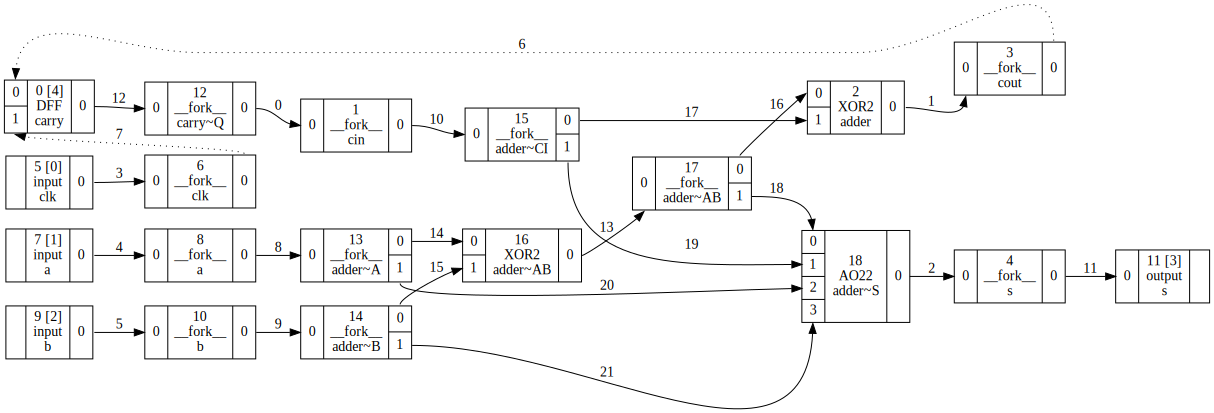

In [39]:
adder.dot()

The graph is getting quite big due to all the forks. If we don't need the signal names anymore, we can remove all forks that only connect to one successor node.

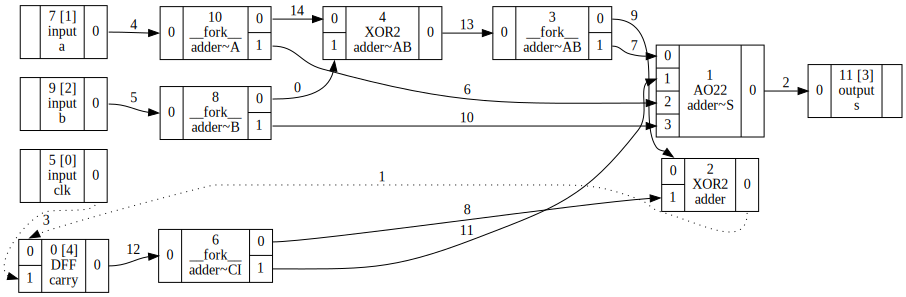

In [40]:
adder.eliminate_1to1_forks()
adder.dot()

Let's resolve the b15 circuit as well.

In [41]:
b15_prim = b15.copy()
b15_prim.resolve_tlib_cells(SAED32)
b15_prim.stats

{'__node__': 22819,
 '__cell__': 11653,
 '__fork__': 11166,
 '__io__': 111,
 '__line__': 33313,
 '__const1__': 1,
 '__comb__': 11125,
 'BUF1': 526,
 'INV1': 897,
 'AND2': 1464,
 'OR2': 1095,
 'NOR2': 114,
 'DFF': 417,
 '__dff__': 417,
 'NAND2': 6611,
 'output': 71,
 'input': 40,
 'MUX21': 417,
 '__latch__': 0,
 '__seq__': 417}

The resolved circuit `b15_prim` contains primitive DFF and no scan-cells.
The scan-chain is still present but it now contains ordinary multiplexers and flip-flops.

In [42]:
for l in b15_prim.s_locs('InstQueue_reg'):
    print('---------------')
    for i in l:
        print(b15_prim.s_nodes[i])

---------------
1385:DFF"InstQueue_reg_0__0_" <32766 <12707 >32767
1383:DFF"InstQueue_reg_0__1_" <32763 <12702 >32764
1387:DFF"InstQueue_reg_0__2_" <32769 <12712 >32770
1381:DFF"InstQueue_reg_0__3_" <32760 <12697 >32761
1389:DFF"InstQueue_reg_0__4_" <32772 <12717 >32773
1379:DFF"InstQueue_reg_0__5_" <32757 <12692 >32758
1391:DFF"InstQueue_reg_0__6_" <32775 <12722 >32776
1377:DFF"InstQueue_reg_0__7_" <32754 <12687 >32755
---------------
1401:DFF"InstQueue_reg_1__0_" <32790 <12747 >32791
1399:DFF"InstQueue_reg_1__1_" <32787 <12742 >32788
1403:DFF"InstQueue_reg_1__2_" <32793 <12752 >32794
1397:DFF"InstQueue_reg_1__3_" <32784 <12737 >32785
1405:DFF"InstQueue_reg_1__4_" <32796 <12757 >32797
1395:DFF"InstQueue_reg_1__5_" <32781 <12732 >32782
1407:DFF"InstQueue_reg_1__6_" <32799 <12762 >32800
1393:DFF"InstQueue_reg_1__7_" <32778 <12727 >32779
---------------
1417:DFF"InstQueue_reg_2__0_" <32814 <12787 >32815
1415:DFF"InstQueue_reg_2__1_" <32811 <12782 >32812
1419:DFF"InstQueue_reg_2__2_" <328

## Working With Logic Values

Sequential states of circuits, signals, and test patterns contain logic values.

KyuPy provides some useful tools to deal with 2-valued, 4-valued, and 8-valued logic data.

All logic values are stored in numpy arrays of dtype `np.uint8`.

There are two storage formats:
* `mv` (for "multi-valued"): Each logic value is stored as uint8
* `bp` (for "bit-parallel"): Groups of 8 logic values are stored as three uint8

### `mv` Arrays

Suppose we want to simulate the adder circuit with 2 inputs, 1 output and 1 flip-flop.

In [43]:
adder.s_nodes

[5:input"clk" >3,
 7:input"a" >4,
 9:input"b" >5,
 11:output"s" <2,
 0:DFF"carry" <1 <3 >12]

We can construct a set of vectors using the `mvarray` helper function.

Each vector has 4 elements, one for each io_node and sequential element.

This would be an exhaustive vector set (the output in `s_nodes` remains unassigned ("-")):

In [44]:
from kyupy import logic

inputs = logic.mvarray('000-0', '010-0', '001-0', '011-0', '000-1', '010-1', '001-1', '011-1')
inputs

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 0, 3, 0, 3, 0, 3],
       [0, 0, 3, 3, 0, 0, 3, 3],
       [2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 0, 0, 3, 3, 3, 3]], dtype=uint8)

The numeric values in this array are defined in `kyupy.logic`.
A logic-0 is stored as `0`, a logic-1 is stored as `3`, and 'unassigned' is stored as `2`.

The **last** axis is always the number of vectors. It may be unintuitive at first, but it is more convenient for data-parallel simulations.

The **second-to-last** axis corresponds to `s_nodes`. I.e., the first row is for input 'a', the second row for input 'b', and so on.

In [45]:
inputs.shape

(5, 8)

Get a string representation of a vector set. Possible values are '0', '1', '-', 'X', 'R', 'F', 'P', and 'N'.

In [46]:
print(logic.mv_str(inputs))

000-0
010-0
001-0
011-0
000-1
010-1
001-1
011-1


Load a stuck-at fault test pattern set and expected fault-free responses from a STIL file. It contains 678 test vectors. Use the resolved circuit for arranging the patterns because the DFF positions may have changed by replacing the original technology cells.

In [47]:
from kyupy import stil

s = stil.load('../tests/b15_2ig.sa_nf.stil.gz')
stuck_tests = s.tests(b15_prim)
stuck_responses = s.responses(b15_prim)

In [48]:
len(b15_prim.s_nodes)

528

In [49]:
stuck_tests.shape

(528, 678)

In [50]:
stuck_responses.shape

(528, 678)

In [51]:
print(logic.mv_str(stuck_tests[:,:5]))

------------------------------------------------------------------------------------------------------0----00--000110110011010011101101001011010010110100101101001001100110011001100110011001100011001100110011001100110011001110011001100110011001100110011001011101001011010010110100101101001011010010110100101101001011101100110011001101100110000010010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101011100110011001100110011001100110011111100001001011000100
--------------------------------------1100011011011111--------10111110--------------------------------P-00000--0101111000011010-01----110---110-110---110-11001100110-11101010011010-10-1010-1010101010-10-10-1010-10-10-10-101-10101010101010-10-10100-01010101011-01-11101110111011101-101-111011101-111011101-111010101000-10-1010-101010010-10011--0100-100110000111100001-111111-000011100000-101-01000011110-11-001000011111111-0001010100010001000----1----1-----1---11---------

In [52]:
print(logic.mv_str(stuck_responses[:,:5]))

11001100110011001100110011001100110000--------------------------------01001100110011001100110011001100--------0000110110011010011101101001011010010110100101101001001100110011001100110011001100011001100110011001100110011001110011001100110011001100110011001011101001011010010110100101101001011010010110100101101001011101100110011001101100110000010010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101011100110011001100110011001100110011111100001001011000100
X0101010101010101X0101X01010101010XX11--------------------------------001X01X01X01X0101X01X01X01010101--------X0001010110000010X01XXXX110XXX110X110XXX110X11001100110X11101010011010X10X1010X1010101010X10X10X1010X10X10X10X101X10101010101010X10X10100X01010101110X00X01000100010001000X000X010001000X010001000X010000000000X10X1010X101010010X10001XX0100X100110000111100001X111111X000011100000X101X01000011110X11X001000011111111X0001010100010001000111101101111011011000001100111

The order of values in the vectors correspond to the circuit's `s_nodes`.
The test data can be used directly in the simulators as they use the same ordering convention.

`stuck_tests` has values for all primary inputs and scan flip-flops, `stuck_responses` contains the expected values for all primary outputs and scan flip-flops.

Since this is a static test, only '0', '1' and 'X' are used with the exception of the clock input, which has a positive pulse 'P'.

A transition fault test is a dynamic test that also contains 'R' for rising transition and 'F' for falling transition:

In [53]:
s = stil.load('../tests/b15_2ig.tf_nf.stil.gz')
transition_tests = s.tests_loc(b15_prim)
transition_responses = s.responses(b15_prim)

STIL files for delay tests usually only contain the initialization patterns.
When loading launch-on-capture transition fault tests, use `.tests_loc()`. This function performs a logic simulation of the launch cycle to calculate the transitions for the delay test itself.

In [54]:
print(logic.mv_str(transition_tests[:,:5]))

------------------------------------------------------------------------------------------------------X----XX--000110110011010011101101001011010010110100101101001001100110011001100110011001100011001100110011001100110011001110011001100110011001100110011001011101001011010010110100101101001011010010110100101101001011101100110011001101100110000010010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101011100110011001100110011001100110011111100001001011000100
--------------------------------------RFRRRRFRRFRRRR1R--------RXXRXRRR--------------------------------00F0F00--RR1RRXRF00011010XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX011X00XXX101X1X1X1X1X1X1X1X1X1X1X1X1X1X1X1X1X1X1X1X1X0XXXXXXX1XXXXXXXXXXXXXXXXXXXXXXXXRRXRXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX000000000000000001111110000010

In [55]:
print(logic.mv_str(transition_responses[:,:5]))

11001100110011001100110011001100110000--------------------------------01001100110011001100110011001100--------0000110110011010011101101001011010010110100101101001001100110011001100110011001100011001100110011001100110011001110011001100110011001100110011001011101001011010010110100101101001011010010110100101101001011101100110011001101100110000010010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101011100110011001100110011001100110011111100001001011000100
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX1--------------------------------0XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX--------X01001X0110000010XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX011X00XXX000X0X0X0X0X0X0X0X0X0X0X0X0X0X0X0X0X0X0X0X0X1XXXXXXX1XXXXXXXXXXXXXXXXXXXXXXXX11X1XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX111111111111111110000001111101

Initialization patterns and launch patterns can be filtered by providing a call-back function. This can be used to fill in unassigned values.

In [56]:
import numpy as np

def zero_fill(mva):
    return np.choose(mva, logic.mvarray('0X01PRFN'))  # maps '0X-1PRFN' -> '0X01PRFN'

transition_tests_zf = s.tests_loc(b15_prim, init_filter=zero_fill, launch_filter=zero_fill)

In [57]:
print(logic.mv_str(transition_tests_zf[:,:5]))

000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000110110011010011101101001011010010110100101101001001100110011001100110011001100011001100110011001100110011001110011001100110011001100110011001011101001011010010110100101101001011010010110100101101001011101100110011001101100110000010010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101011100110011001100110011001100110011111100001001011000100
00000000000000000000000000000000000000RFRRRRFRRFRRRR1R00000000RRRRRRRR0000000000000000000000000000000000F0F0000RR1RR0RF00011010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001100000010101010101010101010101010101010101010101010000000001000000000000000000000000RR0R0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111110000010

### `bp` Arrays

The logic simulator uses bit-parallel storage of logic values, but our loaded test data uses one `uint8` per logic value.

Use `mv_to_bp` to convert mv data to the bit-parallel storage layout.
Bit-parallel storage is more compact, but individual values cannot be easily accessed anymore.

In [58]:
stuck_tests_bp = logic.mv_to_bp(stuck_tests)

In [59]:
stuck_tests_bp.data.shape

(528, 3, 85)

Instead of 678 bytes per s_node, bit-parallel storage only uses 3*85=255 bytes.

The reverse operation is `bp_to_mv`. Note that the number of vectors may be rounded up to the next multiple of 8:

In [60]:
logic.bp_to_mv(stuck_tests_bp).shape

(528, 680)

## Logic Simulation

The following code performs a 8-valued logic simulation on all 678 vectors for one clock cycle.

In [61]:
from kyupy.logic_sim import LogicSim

sim = LogicSim(b15_prim, sims=stuck_tests.shape[-1])  # 678 simulations in parallel
sim.s[0] = stuck_tests_bp
sim.s_to_c()
sim.c_prop()
sim.c_to_s()
sim_responses = logic.bp_to_mv(sim.s[1])[...,:stuck_tests.shape[-1]]  # trim from 680 -> 678

In [62]:
print(logic.mv_str(sim_responses[:,:5]))

11001100110011001100110011001100110000--------------------------------01001100110011001100110011001100--------010X110XXX011010011101101001011010010110100101101001001100110011001100110011001100011001100110011001100110011001110011001100110011001100110011001011101001011010010110100101101001011010010110100101101001011101100110011001101100110000010010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101011100110011001100110011001100110011111100001001011000100
-0101010101010101-0101-01010101010--11--------------------------------001-01-01X01-0101-01-01-01010101---------0001010110000010X01XXXX110XXX110X110XXX110X11001100110X11101010011010X10X1010X1010101010X10X10X1010X10X10X10X101X10101010101010X10X10100X01010101110X00X01000100010001000X000X010001000X010001000X010000000000X10X1010X101010010X10001XX0100X100110000111100001X111111X000011100000X101X01000011110X11X001000011111111X0001010100010001000111101101111011011000001100111

Compare simulation results to expected fault-free responses loaded from STIL.

The first test fails, because it is a flush test while simulation implicitly assumes a standard test with a capture clock.

The remaining 677 responses should be compatible.

The following checks for compatibility (unknown/unassigned values in STIL always match).

In [63]:
np.sum(np.min((sim_responses == stuck_responses) | 
              (stuck_responses == logic.UNASSIGNED) | 
              (stuck_responses == logic.UNKNOWN), axis=0))

677

Same simulation for the transition-fault test set:

In [64]:
sim = LogicSim(b15_prim, sims=transition_tests_zf.shape[-1])  # 1147 simulations in parallel
sim.s[0] = logic.mv_to_bp(transition_tests_zf)
sim.s_to_c()
sim.c_prop()
sim.c_to_s()
sim_responses = logic.bp_to_mv(sim.s[1])[...,:transition_tests_zf.shape[-1]]  # trim to 1147

In [65]:
print(logic.mv_str(sim_responses[:,:5]))

11001100110011001100110011001100110000--------------------------------01001100110011001100110011001100--------0100110001011010011101101001011010010110100101101001001100110011001100110011001100011001100110011001100110011001110011001100110011001100110011001011101001011010010110100101101001011010010110100101101001011101100110011001101100110000010010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101011100110011001100110011001100110011111100001001011000100
0000000000000000000000000000000000000R--------------------------------00000000000000000000000000000000--------0FNFFNPFRR0PFF01000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000NNP0PP00F0FPFPFPFPFPFPFPFPFPFPFPFPFPFPFPFPF0F0F0F0FPRP0P0P0PN000000000000000000000000NNPNP000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000RRRRRRRRRRRRRRRRRFFFFFFRRRRRFR

The simulator responses contain 'R' for rising transition, 'F' for falling transition, 'P' for possible positive pulse(s) (010) and 'N' for possible negative pulse(s) (101).

We need to map each of these cases to the final logic values before we can compare:

In [66]:
sim_responses_final = np.choose(sim_responses, logic.mvarray('0X-10101'))  # maps '0X-1PRFN' -> '0X-10101'
print(logic.mv_str(sim_responses_final[:,:5]))

11001100110011001100110011001100110000--------------------------------01001100110011001100110011001100--------0100110001011010011101101001011010010110100101101001001100110011001100110011001100011001100110011001100110011001110011001100110011001100110011001011101001011010010110100101101001011010010110100101101001011101100110011001101100110000010010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101011100110011001100110011001100110011111100001001011000100
00000000000000000000000000000000000001--------------------------------00000000000000000000000000000000--------0010010011000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000110000000000000000000000000000000000000000000000000010000000100000000000000000000000011010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111111111111110000001111101

Again, first test is a flush test, so we expect 1146 matches.

We simulated zero-filled patterns and therefore have more specified output bits.

The following checks for compatability (unknown/unassigned values in STIL always match).

In [67]:
np.sum(np.min((sim_responses_final == transition_responses) | 
              (transition_responses == logic.UNASSIGNED) | 
              (transition_responses == logic.UNKNOWN), axis=0))

1146

# Working With Delay Information and Timing Simulation

Delay data for gates and interconnect can be loaded from SDF files. In kyupy's timing simulators, delays are associated with the lines between nodes, not with the nodes themselves.
Each line in the circuit has 4 delays for the IOPATH of the reading node;
one for each combination rising/falling edges at the input and output of that node.

These contents of the SDF file is matched by node names to the original (non-resolved) circuit `b15`. Resolving library cells does not change the line indices, so the resulting array is compatible with `b15_prim`.

In [68]:
from kyupy import sdf

df = sdf.load('../tests/b15_2ig.sdf.gz')
delays = df.iopaths(b15, tlib=SAED32)[0]

The returned delay information is an `ndarray` with a set of delay values for each line in the circuit.

In [69]:
delays.shape

(32032, 2, 2)

Number of non-0 values loaded:

In [70]:
(delays != 0).sum()

79010

The available timing simulators are `WaveSim` and `WaveSimCuda`.
They work similarly to `LogicSim` in that they evaluate all cells in topological order.
Instead of propagating a logic value, however, they propagate waveforms.

`WaveSim` uses the numba just-in-time compiler for acceleration on CPU.
It falls back to pure python if numba is not available. `WaveSimCuda` uses numba for GPU acceleration.
If no CUDA card is available, it will fall back to pure python (not jit-compiled for CPU!).
Pure python is too slow for most purposes.

Both simulators operate data-parallel.
The following instanciates a new engine for 32 independent timing simulations and each signal line in the circuit can carry at most 16 transitions. All simulators share the same circuit and the same line delay specification.

In [71]:
from kyupy.wave_sim import WaveSimCuda, TMAX

wsim = WaveSimCuda(b15_prim, delays, sims=32, c_caps=16)

These are various memories allocated, with waveforms usually being the largest. 

In [72]:
def print_mem(name, arr):
    print(f'{name}: {arr.nbytes / 1024:.1f} kiB')
    
print_mem('Waveforms              ', wsim.c)
print_mem('State Allocation Table ', wsim.c_locs)
print_mem('Circuit Timing         ', wsim.delays)
print_mem('Circuit Netlist        ', wsim.ops)
print_mem('Sequential State       ', wsim.s)

Waveforms              : 66856.0 kiB
State Allocation Table : 134.3 kiB
Circuit Timing         : 1074.1 kiB
Circuit Netlist        : 1171.2 kiB
Sequential State       : 726.0 kiB


This is a typical simulation loop where the number of patterns is larger than the number of simulators available.
We simulate `transition_tests_zf`.
The initial values, transition times and final values are loaded into `wsim.s` and the following three calls will update this array with simulation results. We collect all results in `wsim_results`.

In [73]:
from kyupy import batchrange
import numpy as np

sims = 128  # transition_tests_zf.shape[-1]  # Feel free to simulate all tests if CUDA is set up correctly.

wsim_results = np.zeros((11, wsim.s_len, sims))  # space to store all simulation results

for offset, size in batchrange(sims, wsim.sims):
    wsim.s[0] = (transition_tests_zf[:,offset:offset+size] >> 1) & 1  # initial value (bit 1)
    wsim.s[1] = 0.0 # transition time
    wsim.s[2] = transition_tests_zf[:,offset:offset+size] & 1  # final value (bit 0)
    wsim.s_to_c()
    wsim.c_prop(sims=size)
    wsim.c_to_s(time=1.5)  # capture at time 1.5
    wsim_results[:,:,offset:offset+size] = wsim.s[:,:,:size]

The arrays `wsim.s` and `wsim_results` contain various information for each PI, PO, and scan flip-flop (axis 1), and each test (axis 2):
* ``s[0]`` (P)PI initial value
* ``s[1]`` (P)PI transition time
* ``s[2]`` (P)PI final value
* ``s[3]`` (P)PO initial value
* ``s[4]`` (P)PO earliest arrival time (EAT): The time at which the output transitioned from its initial value.
* ``s[5]`` (P)PO latest stabilization time (LST): The time at which the output settled to its final value.
* ``s[6]`` (P)PO final value
* ``s[7]`` (P)PO capture value: probability of capturing a 1 at a given capture time
* ``s[8]`` (P)PO sampled capture value: decided by random sampling according to a given seed.
* ``s[9]`` (P)PO sampled capture slack: (capture time - LST) - decided by random sampling according to a given seed.
* ``s[10]`` Overflow indicator: If non-zero, some signals in the input cone of this output had more
          transitions than specified in ``c_caps``. Some transitions have been discarded, the
          final values in the waveforms are still valid.

In [74]:
wsim_results.shape

(11, 528, 128)

For validating against known logic values, convert the samples capture values `wsim_results[8]` into an mvarray like this:

In [75]:
wsim_responses_final = ((wsim_results[8] > 0.5) * logic.ONE).astype(np.uint8)
print(logic.mv_str(wsim_responses_final[:,:5]))

110011001100110011001100110011001100000000000000000000000000000000000001001100110011001100110011001100000000000100110001011010011101101001011010010110100101101001001100110011001100110011001100011001100110011001100110011001110011001100110011001100110011001011101001011010010110100101101001011010010110100101101001011101100110011001101100110000010010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101011100110011001100110011001100110011111100001001011000100
000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000010010011000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000110000000000000000000000000000000000000000000000000010000000100000000000000000000000011010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111111111111110000001111101

We expect 127 matches here.

In [76]:
np.sum(np.min((wsim_responses_final == transition_responses[:,:sims]) | 
              (transition_responses[:,:sims] == logic.UNASSIGNED) | 
              (transition_responses[:,:sims] == logic.UNKNOWN), axis=0))

127

The circuit delay is the maximum among all latest stabilization times:

In [77]:
wsim_results[5].max()

1.0424000024795532

Check for overflows. If too many of them occur, increase `c_caps` during engine instanciation:

In [78]:
wsim_results[10].sum()

0.0

Check for capture failures by comparing the samples PPO capture value with the final PPO value:

In [79]:
(wsim_results[6] != wsim_results[8]).sum()

0